In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.utils import scatter
from data_loader import get_dblp_data

In [204]:
def scatter_mean(src, index, dim_size):
    """Robust scatter mean implementation"""
    return scatter(src, index, dim=0, dim_size=dim_size, reduce='mean')

In [205]:
class MetapathLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x_src, x_dst, edge_index):
        src, dst = edge_index
        query = x_dst[dst].unsqueeze(0)
        key = x_src[src].unsqueeze(0)
        value = key
        
        attn_out, _ = self.attention(query, key, value)
        attn_out = attn_out.squeeze(0)
        
        aggregated = scatter(attn_out, dst, dim=0, reduce='mean')
        return self.norm(aggregated + x_dst)
class metapath_classifier(nn.Module):
    def __init__(self, in_dims, hidden_dim, out_dim, metapaths):
        super().__init__()
        self.metapaths = metapaths
        
        # Node projections
        self.projections = nn.ModuleDict({
            ntype: nn.Linear(dim, hidden_dim)
            for ntype, dim in in_dims.items()
        })
        
        # Dynamic processor initialization
        self.processors = nn.ModuleList([
            nn.ModuleList([MetapathLayer(hidden_dim) for _ in range(len(mp)-1)])
            for mp in metapaths
        ])
        
        # Fusion and classification
        self.fusion = nn.TransformerEncoderLayer(hidden_dim, nhead=4)
        self.classifier = nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        x_dict = {
            ntype: proj(data[ntype].x)
            for ntype, proj in self.projections.items()
        }
        
        metapath_embeddings = []
        for mp_idx, metapath in enumerate(self.metapaths):
            current_type = metapath[0]
            x = x_dict[current_type]
            
            for step in range(len(metapath)-1):
                next_type = metapath[step+1]
                edge_type = (current_type, 'to', next_type)
                
                # Handle missing edges gracefully
                if edge_type not in data.edge_index_dict:
                    break
                
                edge_index = data.edge_index_dict[edge_type]
                x = self.processors[mp_idx][step](
                    x,
                    x_dict[next_type],
                    edge_index
                )
                current_type = next_type
            
            # Final aggregation to author
            if current_type == 'author':
                metapath_embeddings.append(x)
            else:
                if (current_type, 'to', 'author') in data.edge_index_dict:
                    edge_index = data.edge_index_dict[(current_type, 'to', 'author')]
                    final_agg = scatter_mean(
                        x[edge_index[0]],
                        edge_index[1],
                        dim_size=data['author'].num_nodes
                    )
                    metapath_embeddings.append(final_agg)

        if not metapath_embeddings:
            return torch.zeros(data['author'].num_nodes, self.classifier.out_features)
        
        # Fusion and classification
        stacked = torch.stack(metapath_embeddings, dim=1)
        fused = self.fusion(stacked).mean(dim=1)
        return self.classifier(fused)

In [206]:
class RelationalAttention(nn.Module):
    """True attention across relations with explainable scores"""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        # For explanation scores
        self.attention_scores = None
        
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.xavier_uniform_(self.key.weight)

    def forward(self, src_emb, dst_emb):
        # Compute attention scores
        q = self.query(src_emb)  # [num_edges, hidden]
        k = self.key(dst_emb)    # [num_edges, hidden]
        
        # Scaled dot-product attention
        logits = (q * k).sum(dim=-1) / torch.sqrt(torch.tensor(k.size(-1)))
        
        # Store for explanation
        self.attention_scores = logits
        
        return F.softmax(logits, dim=0)  # Normalize across relations
class MetapathGenerator(nn.Module):
    """Dynamically generates and scores metapaths"""
    def __init__(self, node_dims, hidden_dim=256, seed_types=('author', 'paper'), max_length=3):
        super().__init__()
        self.seed_types = seed_types
        self.max_length = max_length
        
        # Node feature projections
        self.node_projections = nn.ModuleDict({
            ntype: nn.Linear(dim, hidden_dim)
            for ntype, dim in node_dims.items()
        })
        
        self.rel_attn = RelationalAttention(hidden_dim)

    def generate_metapaths(self, edge_index_dict):
        """Generate metapaths up to max_length from seed nodes without direct self-loops"""
        metapaths = []
        current_paths = [[(st,)] for st in self.seed_types]  # Start with seed node types
        
        for _ in range(self.max_length):
            new_paths = []
            for path in current_paths:
                last_edge = path[-1]
                for edge_type in edge_index_dict.keys():
                    if edge_type[0] == last_edge[-1]:
                        new_paths.append(path + [edge_type])
            
            # Filter direct self-loops before adding to metapaths
            valid_paths = []
            for path in current_paths:
                node_path = self._convert_to_node_path(path)
                # Skip if it's a direct self-loop (e.g., paper->paper without intermediate nodes)
                if len(node_path) <= 1 or not (len(set(node_path)) == 1):
                    valid_paths.append(path)
            
            metapaths.extend(valid_paths)
            current_paths = new_paths
        
        # Process the final batch of paths
        valid_final = []
        for path in current_paths:
            node_path = self._convert_to_node_path(path)
            if len(node_path) <= 1 or not (len(set(node_path)) == 1):
                valid_final.append(path)
        
        metapaths.extend(valid_final)
        return metapaths


    def forward(self, data):
        # Project node features
        x_dict = {
            ntype: proj(data[ntype].x)
            for ntype, proj in self.node_projections.items()
        }
        
        # Compute relation attention weights
        all_weights = []
        edge_types = []
        
        for edge_type, edge_index in data.edge_index_dict.items():
            src_type, _, dst_type = edge_type
            if src_type in x_dict and dst_type in x_dict:
                src_idx = edge_index[0].clamp(0, x_dict[src_type].size(0)-1)
                dst_idx = edge_index[1].clamp(0, x_dict[dst_type].size(0)-1)
                
                src_emb = x_dict[src_type][src_idx]
                dst_emb = x_dict[dst_type][dst_idx]
                
                # Get attention scores for this relation
                weights = self.rel_attn(src_emb, dst_emb)
                all_weights.append(weights.mean())
                edge_types.append(edge_type)
        
        # Normalize across all relations
        norm_weights = F.softmax(torch.tensor(all_weights), dim=0)
        relation_weights = {et: nw.item() for et, nw in zip(edge_types, norm_weights)}
        
        # Store for explanation
        self.relation_weights = relation_weights

        # Generate and score metapaths
        metapaths = self.generate_metapaths(data.edge_index_dict)
        # Step 3: Group metapaths by length for proper attention
        metapaths_by_length = {}
        for path in metapaths:
            node_path = self._convert_to_node_path(path)
            path_length = len(node_path)
            if path_length not in metapaths_by_length:
                metapaths_by_length[path_length] = []
            metapaths_by_length[path_length].append(path)
        
        # Step 4: Apply attention to metapaths of same length
        scored_metapaths = []
        for length, paths in metapaths_by_length.items():
            # Calculate initial scores using relation weights
            path_scores = []
            for path in paths:
                score = 1.0
                for edge_type in path:
                    score *= relation_weights.get(edge_type, 0.1)  # Default minimum score
                path_scores.append(score)
            
            # Apply softmax attention within same length group
            if path_scores:
                normalized_scores = F.softmax(torch.tensor(path_scores), dim=0)
                for i, path in enumerate(paths):
                    scored_metapaths.append((path, normalized_scores[i].item()))
        
        # Store for explanation
        self.raw_metapaths = scored_metapaths
        return scored_metapaths
    def _convert_to_node_path(self, edge_path):
        """Convert edge-type path to node-type sequence"""
        if not edge_path:
            return []
            
        node_path = [edge_path[0][0]]  # Start with source node type of first edge
        for edge in edge_path:
            node_path.append(edge[-1])  # Add destination node type
        
        return node_path

class DynamicMetapath(nn.Module):
    """Integrated model with dynamic metapath selection"""
    def __init__(self, in_dims, hidden_dim, num_classes, 
                 seed_types=('author', 'paper'), max_metapath_length=3):
        super().__init__()
        self.metapath_generator = MetapathGenerator(
            in_dims, hidden_dim, seed_types, max_metapath_length
        )
        self.classifier = metapath_classifier(in_dims, hidden_dim, num_classes, metapaths=[])
        self.default_metapaths = [
            ['author', 'paper', 'author'],
            ['paper', 'author']
        ]
        self.top_metapaths = [] 
        self.scores = []

    def _convert_to_node_path(self, edge_path):
        """Convert edge-type path to node-type sequence"""
        if not edge_path:
            return []
            
        node_path = [edge_path[0][0]]  # Start with source node type of first edge
        for edge in edge_path:
            node_path.append(edge[-1])  # Add destination node type
        
        return node_path

    def forward(self, data):
        # Generate metapaths
        scored_metapaths = self.metapath_generator(data)
        self.raw_metapaths = scored_metapaths
        sorted_metapaths = sorted(scored_metapaths, key=lambda x: x[1].item() if isinstance(x[1], torch.Tensor) else x[1], reverse=True)
        self.top_metapaths = [
            (path, self._convert_to_node_path(path), score)
            for path, score in sorted_metapaths
        ]
        # Select top metapaths with score > 0
        valid_metapaths = [path for path, score in scored_metapaths if score > 0]
        
        # Fallback to default if none found
        if not valid_metapaths:
            valid_metapaths = self.default_metapaths
        else:
            valid_metapaths = [path for path, _ in scored_metapaths][:2]  # Top 2 paths

        # Convert to node sequences
        node_metapaths = [self._convert_to_node_path(p) for p in valid_metapaths]
        
        # Update SeHGNN with new metapaths
        self.classifier.metapaths = node_metapaths
        return self.classifier(data)
    def get_top_metapaths(self, k=5, format='node'):
        """Returns top k metapaths with scores"""
        results = []
        for i, (edge_path, node_path, score) in enumerate(self.top_metapaths[:k]):
            # Handle both tensor and float scores
            score_val = score.item() if isinstance(score, torch.Tensor) else score
            if format == 'node':
                results.append((' -> '.join(node_path), score_val))
            else:
                results.append((' | '.join([str(e) for e in edge_path]), score_val))
        return results


    def get_all_metapath_scores(self):
        """Returns all metapaths with scores"""
        return [
            (self._convert_to_node_path(p), s.item() if isinstance(s, torch.Tensor) else s) 
            for p, s in self.raw_metapaths
        ]
    def get_raw_metapaths(self):
        return self.raw_metapaths
    def get_relation_importance(self):
        """Returns relation importance scores"""
        return self.metapath_generator.relation_weights
    
    def get_attention_explanations(self):
        """Returns raw attention scores for analysis"""
        return {
            'relation_scores': self.metapath_generator.rel_attn.attention_scores,
            'metapath_scores': self.top_metapaths
        }

In [207]:
data.edge_index_dict.keys()

dict_keys([('author', 'to', 'paper'), ('paper', 'to', 'author'), ('paper', 'to', 'term'), ('paper', 'to', 'conference'), ('term', 'to', 'paper'), ('conference', 'to', 'paper')])

In [208]:
def train_model(data, model, epochs=100, model_name="dynamic"):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val = 0

    # Ensure CPU
    data = data.cpu()
    model = model.cpu()

    # Verify features
    for ntype in data.node_types:
        if not hasattr(data[ntype], 'x'):
            data[ntype].x = torch.ones(data[ntype].num_nodes, 1)

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        
        # Calculate loss
        loss = criterion(
            out[data['author'].train_mask],
            data['author'].y[data['author'].train_mask]
        )
        
        # Backprop
        loss.backward()
        optimizer.step()

        # Validation
        with torch.no_grad():
            pred = out.argmax(dim=1)
            val_acc = (pred[data['author'].val_mask] == data['author'].y[data['author'].val_mask]).float().mean()
            
            if val_acc > best_val:
                best_val = val_acc
                torch.save(model.state_dict(), f'{model_name}.pth')

        print(f'Epoch {epoch:03d} | Loss: {loss:.4f} | Val: {val_acc:.4f}')

    # model.load_state_dict(torch.load(f'{model_name}.pth'))
    # return model

In [209]:
from data_loader import get_dblp_data

In [210]:
data = get_dblp_data()

Final split sizes:
Training: 3245 (80.0%)
Validation: 406 (10.0%)
Test: 406 (10.0%)


In [212]:
for ntype in data.node_types:
    if not hasattr(data[ntype], 'x'):
        data[ntype].x = torch.ones(data[ntype].num_nodes, 1)

in_dims = {ntype: data[ntype].x.size(1) for ntype in data.node_types}

model = DynamicMetapath(
    in_dims=in_dims,
    hidden_dim=256,
    num_classes=4,
    max_metapath_length=4,
    seed_types=('paper','author','conference')
)

# Train using your existing code
train_model(data, model, epochs=100,model_name="test")

Epoch 000 | Loss: 1.5349 | Val: 0.2340
Epoch 001 | Loss: 2.1750 | Val: 0.4778
Epoch 002 | Loss: 1.9895 | Val: 0.4483
Epoch 003 | Loss: 1.0736 | Val: 0.6478
Epoch 004 | Loss: 0.4705 | Val: 0.7611
Epoch 005 | Loss: 0.3623 | Val: 0.8128
Epoch 006 | Loss: 0.4292 | Val: 0.7291
Epoch 007 | Loss: 0.2987 | Val: 0.7759
Epoch 008 | Loss: 0.1683 | Val: 0.8547
Epoch 009 | Loss: 0.1166 | Val: 0.8744
Epoch 010 | Loss: 0.1123 | Val: 0.8916
Epoch 011 | Loss: 0.1170 | Val: 0.8842
Epoch 012 | Loss: 0.1079 | Val: 0.8892
Epoch 013 | Loss: 0.0893 | Val: 0.8867
Epoch 014 | Loss: 0.0702 | Val: 0.8793
Epoch 015 | Loss: 0.0556 | Val: 0.8793
Epoch 016 | Loss: 0.0454 | Val: 0.8818
Epoch 017 | Loss: 0.0397 | Val: 0.8695
Epoch 018 | Loss: 0.0377 | Val: 0.8596
Epoch 019 | Loss: 0.0360 | Val: 0.8547
Epoch 020 | Loss: 0.0331 | Val: 0.8522
Epoch 021 | Loss: 0.0294 | Val: 0.8547
Epoch 022 | Loss: 0.0249 | Val: 0.8547
Epoch 023 | Loss: 0.0201 | Val: 0.8670
Epoch 024 | Loss: 0.0167 | Val: 0.8719
Epoch 025 | Loss: 0.0146 

In [213]:
# After training
model.eval()

# Get relation importance scores
relation_importance = model.get_relation_importance()
print("Relation Importance:")
for rel, score in relation_importance.items():
    print(f"{rel}: {score:.4f}")

# Get top metapaths with valid paths
print("\nTop Valid Metapaths:")
for path, score in model.get_top_metapaths(5):
    print(f"{path} | Score: {score:.4f}")

Relation Importance:
('author', 'to', 'paper'): 0.1667
('paper', 'to', 'author'): 0.1667
('paper', 'to', 'term'): 0.1667
('paper', 'to', 'conference'): 0.1667
('term', 'to', 'paper'): 0.1667
('conference', 'to', 'paper'): 0.1667

Top Valid Metapaths:
paper -> paper -> conference | Score: 0.2000
conference -> conference -> paper | Score: 0.2000
paper -> paper -> author | Score: 0.2000
author -> author -> paper | Score: 0.2000
paper -> paper -> term | Score: 0.2000


In [214]:
model.get_raw_metapaths()

[([('paper',), ('paper', 'to', 'author')], 0.20000000298023224),
 ([('paper',), ('paper', 'to', 'term')], 0.1999998688697815),
 ([('paper',), ('paper', 'to', 'conference')], 0.20000006258487701),
 ([('author',), ('author', 'to', 'paper')], 0.20000000298023224),
 ([('conference',), ('conference', 'to', 'paper')], 0.20000006258487701),
 ([('paper',), ('paper', 'to', 'author'), ('author', 'to', 'paper')],
  0.1111111044883728),
 ([('paper',), ('paper', 'to', 'term'), ('term', 'to', 'paper')],
  0.11111108958721161),
 ([('paper',), ('paper', 'to', 'conference'), ('conference', 'to', 'paper')],
  0.111111119389534),
 ([('author',), ('author', 'to', 'paper'), ('paper', 'to', 'author')],
  0.1111111044883728),
 ([('author',), ('author', 'to', 'paper'), ('paper', 'to', 'term')],
  0.11111108958721161),
 ([('author',), ('author', 'to', 'paper'), ('paper', 'to', 'conference')],
  0.1111111119389534),
 ([('conference',), ('conference', 'to', 'paper'), ('paper', 'to', 'author')],
  0.1111111119389

In [215]:
# print("\nAll Metapaths:")
# for path, score in model.get_all_metapath_scores():
#     print(f"{path} | Score: {score:.4f}")

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, data):
    attn_scores = model.get_relation_importance()
    relations = list(attn_scores.keys())
    scores = list(attn_scores.values())
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=scores, y=[f"{r[0]}-{r[2]}" for r in relations])
    plt.title("Relation Importance Scores")
    plt.xlabel("Attention Weight")
    plt.ylabel("Relation Type")
    plt.tight_layout()
    plt.show()


In [217]:
def visualize_top_metapaths(model, k=5):
    top_paths = model.get_top_metapaths(k=k)
    paths, scores = zip(*top_paths)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(scores), y=list(paths))
    plt.title(f"Top {k} Metapaths by Score")
    plt.xlabel("Score")
    plt.ylabel("Metapath")
    plt.tight_layout()
    plt.show()


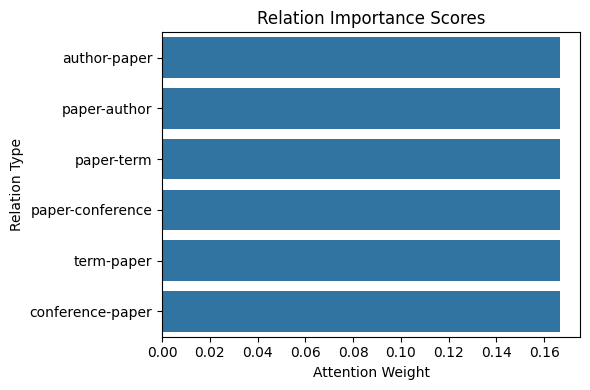

In [218]:
visualize_attention(model,data)

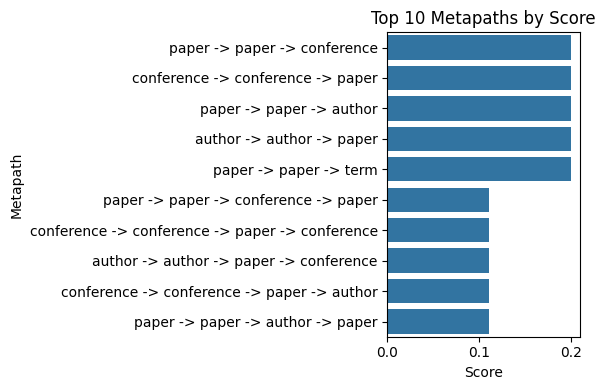

In [219]:
visualize_top_metapaths(model, k=10)